<a href="https://colab.research.google.com/github/keeprich/AI-Trading-Bot/blob/main/udemy_ML_Trading_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install oandapyV20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=3c4f9e14ce0b29f01472d67073ff6a731977935dab417d3260f60dff7bdb692d
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20


In [ ]:
!pip install yfinance

In [ ]:
# Required Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import oandapyV20
from oandapyV20.endpoints.orders import OrderCreate
import logging
import csv
import datetime
import os

# Mapping function for symbol compatibility
def get_oanda_symbol(yf_symbol):
    """
    Converts a Yahoo Finance symbol to an OANDA-compatible symbol.
    - For example, BTC-USD -> BTC_USD for OANDA
    """
    if '-' in yf_symbol:  # For cryptocurrencies like BTC-USD
        return yf_symbol.replace('-', '_')
    return yf_symbol  # For other assets (stocks, forex, etc.), the symbol might not need modification.

# Moving Average Crossover ML Strategy Class
class MovingAverageCrossoverML:
    def __init__(self, config):
        """
        Initialize the strategy with configuration dictionary.
        """
        # Extract configuration values
        self.config = config
        self.api_key = config['api_key']
        self.account_id = config['account_id']
        self.symbol = config['symbol']
        self.short_window = config['short_window']
        self.long_window = config['long_window']
        self.take_profit_pct = config['take_profit_pct']
        self.stop_loss_pct = config['stop_loss_pct']
        self.leverage = config['leverage']
        self.investment_amount = config['investment_amount']

        # Initialize OANDA API
        self.oanda_api = oandapyV20.API(access_token=self.api_key)

        # CSV file setup for logging trades
        self.log_file = 'trade_log.csv'
        self.initialize_trade_log()

        # Set the OANDA-compatible symbol based on Yahoo Finance symbol
        self.oanda_symbol = get_oanda_symbol(self.symbol)

    def initialize_trade_log(self):
        """
        Initialize CSV log file with headers.
        """
        if not os.path.exists(self.log_file):
            with open(self.log_file, mode='w') as file:
                writer = csv.writer(file)
                writer.writerow(['timestamp', 'symbol', 'action', 'price', 'take_profit', 'stop_loss', 'investment'])

    def log_trade(self, action, price, take_profit, stop_loss):
        """
        Log each trade to the CSV file.
        """
        with open(self.log_file, mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([datetime.datetime.now(), self.symbol, action, price, take_profit, stop_loss, self.investment_amount])

    def fetch_data(self):
        """
        Fetch historical data using yfinance and calculate moving averages.
        """
        try:
            data = yf.download(self.symbol, period="1y", interval="1d")
            if data.empty:
                raise ValueError(f"No data found for symbol {self.symbol}. Check the symbol or data source.")
            data['Short_MA'] = data['Close'].rolling(window=self.short_window, min_periods=1).mean()
            data['Long_MA'] = data['Close'].rolling(window=self.long_window, min_periods=1).mean()
            data.dropna(inplace=True)
            return data
        except Exception as e:
            print(f"Error fetching data: {e}")
            return pd.DataFrame()  # Return empty DataFrame on error

    def generate_signals(self, data):
        """
        Generate buy (1) and sell (0) signals based on the crossover of moving averages.
        """
        data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, 0)
        data['Signal'] = data['Signal'].shift(1)  # Shift to avoid lookahead bias
        data.dropna(inplace=True)
        return data

    def train_model(self, data):
        """
        Train a machine learning model using Random Forest to predict signals.
        """
        if data.empty:
            raise ValueError("No data to train the model on.")

        # Prepare the feature matrix and target variable
        features = data[['Short_MA', 'Long_MA']].values
        target = data['Signal'].values

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

        # Initialize and train the RandomForestClassifier
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Predict and evaluate the model
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Model accuracy: {accuracy:.2f}")

        return model

# Place Order function - Update take profit and stop loss calculation
def place_order(self, action, price, take_profit, stop_loss):
    """
    Place a buy/sell order using OANDA's API with validation of price levels.
    """
    # Validate prices
    if take_profit <= 0 or stop_loss <= 0:
        print("Invalid take profit or stop loss price. Prices must be positive.")
        return

    # Make sure take profit is above current price for buy, and below for sell
    if action == "buy" and take_profit <= price:
        print(f"Invalid take profit for buy order. It must be higher than the current price: {price}.")
        return
    elif action == "sell" and take_profit >= price:
        print(f"Invalid take profit for sell order. It must be lower than the current price: {price}.")
        return

    # Ensure stop loss is appropriately positioned for buy and sell
    if action == "buy" and stop_loss >= price:
        print(f"Invalid stop loss for buy order. It must be lower than the current price: {price}.")
        return
    elif action == "sell" and stop_loss <= price:
        print(f"Invalid stop loss for sell order. It must be higher than the current price: {price}.")
        return

    units = self.investment_amount if action == "buy" else -self.investment_amount
    order_data = {
        "order": {
            "units": units,  # Positive for buy, negative for sell
            "instrument": self.oanda_symbol,  # Use the OANDA-compatible symbol
            "price": str(price),
            "takeProfitOnFill": {"price": str(take_profit)},
            "stopLossOnFill": {"price": str(stop_loss)},
            "type": "MARKET",
            "timeInForce": "FOK",
            "positionFill": "DEFAULT"
        }
    }

    # Place order with OANDA
    try:
        response = self.oanda_api.request(OrderCreate(self.account_id, order_data))
        print(f"{action.capitalize()} order placed at {price}")
        self.log_trade(action, price, take_profit, stop_loss)
    except Exception as e:
        print(f"Error placing {action} order: {e}")

    def execute_strategy(self):
        """
        Execute the moving average crossover strategy with machine learning.
        """
        # Fetch and preprocess data
        data = self.fetch_data()
        if data.empty:
            print("No data fetched. Exiting strategy execution.")
            return

        data = self.generate_signals(data)

        # Train model to predict buy/sell signals
        model = self.train_model(data)

        # Get the latest data to make a prediction
        latest_data = data[['Short_MA', 'Long_MA']].values[-1].reshape(1, -1)
        prediction = model.predict(latest_data)[0]

        # Place a buy or sell order based on model's prediction
        last_price = data['Close'].iloc[-1]
        if prediction == 1:  # Buy signal
            take_profit = last_price * (1 + self.take_profit_pct / 100)
            stop_loss = last_price * (1 - self.stop_loss_pct / 100)
            self.place_order("buy", last_price, take_profit, stop_loss)
        elif prediction == 0:  # Sell signal
            take_profit = last_price * (1 - self.take_profit_pct / 100)
            stop_loss = last_price * (1 + self.stop_loss_pct / 100)
            self.place_order("sell", last_price, take_profit, stop_loss)

# Configuration Dictionary


# Configuration Dictionary
config = {
    "api_key": "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e",  # Replace with your OANDA API key
    "account_id": "101-004-30239848-002",  # Replace with your OANDA Account ID
    "symbol": "BTC-USD",  # OANDA symbol format, e.g., BTC_USD
    "short_window": 20,
    "long_window": 50,
    "take_profit_pct": 5,  # Percentage for take profit
    "stop_loss_pct": 3,  # Percentage for stop loss
    "leverage": 2,  # Leverage for the position
    "investment_amount": 1.0,  # Investment amount in the base currency (e.g., 1 BTC)
}



# Initialize and run the strategy
strategy = MovingAverageCrossoverML(config)
strategy.execute_strategy()


AttributeError: 'MovingAverageCrossoverML' object has no attribute 'execute_strategy'

SyntaxError: unterminated string literal (detected at line 226) (<ipython-input-6-7bea356ae03f>, line 226)

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import oandapyV20
from oandapyV20.endpoints.orders import OrderCreate
import logging
import csv
import datetime

class MovingAverageCrossoverML:
    def __init__(self, config):
        self.config = config
        self.api_key = config['api_key']
        self.account_id = config['account_id']
        self.symbol = config['symbol']
        self.short_window = config['short_window']
        self.long_window = config['long_window']
        self.take_profit_pct = config['take_profit_pct']
        self.stop_loss_pct = config['stop_loss_pct']
        self.leverage = config['leverage']
        self.investment_amount = config['investment_amount']

        # Initialize OANDA API
        self.oanda_api = oandapyV20.API(access_token=self.api_key)

        # CSV file setup for logging trades
        self.log_file = 'trade_log.csv'
        self.initialize_trade_log()

    def initialize_trade_log(self):
        with open(self.log_file, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(['timestamp', 'symbol', 'action', 'price', 'take_profit', 'stop_loss', 'investment'])

    def log_trade(self, action, price, take_profit, stop_loss):
        with open(self.log_file, mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([datetime.datetime.now(), self.symbol, action, price, take_profit, stop_loss, self.investment_amount])

    def fetch_data(self):
        data = yf.download(self.symbol, period="1y", interval="1d")
        data['Short_MA'] = data['Close'].rolling(window=self.short_window, min_periods=1).mean()
        data['Long_MA'] = data['Close'].rolling(window=self.long_window, min_periods=1).mean()
        data.dropna(inplace=True)
        return data

    def generate_signals(self, data):
        data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, 0)
        data['Signal'] = data['Signal'].shift(1)
        data.dropna(inplace=True)
        return data

    def train_model(self, data):
        features = data[['Short_MA', 'Long_MA']].values
        target = data['Signal'].values

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Model performance
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Model accuracy: {accuracy:.2f}")

        return model

    def place_order(self, action, price, take_profit, stop_loss):
        if take_profit <= 0 or stop_loss <= 0:
            print("Invalid take profit or stop loss price. Prices must be positive.")
            return

        # Ensure correct price bounds for buy/sell orders
        if action == "buy" and take_profit <= price:
            print(f"Invalid take profit for buy order. It must be higher than the current price: {price}.")
            return
        elif action == "sell" and take_profit >= price:
            print(f"Invalid take profit for sell order. It must be lower than the current price: {price}.")
            return

        if action == "buy" and stop_loss >= price:
            print(f"Invalid stop loss for buy order. It must be lower than the current price: {price}.")
            return
        elif action == "sell" and stop_loss <= price:
            print(f"Invalid stop loss for sell order. It must be higher than the current price: {price}.")
            return

        units = self.investment_amount if action == "buy" else -self.investment_amount
        order_data = {
            "order": {
                "units": units,
                "instrument": self.symbol,
                "price": str(price),
                "takeProfitOnFill": {"price": str(take_profit)},
                "stopLossOnFill": {"price": str(stop_loss)},
                "type": "MARKET",
                "timeInForce": "FOK",
                "positionFill": "DEFAULT"
            }
        }

        try:
            response = self.oanda_api.request(OrderCreate(self.account_id, order_data))
            print(f"{action.capitalize()} order placed at {price}")
            self.log_trade(action, price, take_profit, stop_loss)
        except Exception as e:
            print(f"Error placing {action} order: {e}")

    def execute_strategy(self):
        # Fetch data and preprocess
        data = self.fetch_data()
        data = self.generate_signals(data)

        # Train model
        model = self.train_model(data)

        # Use model to predict latest signal
        latest_data = data[['Short_MA', 'Long_MA']].values[-1].reshape(1, -1)
        prediction = model.predict(latest_data)[0]

        # Place buy/sell order based on prediction
        last_price = data['Close'].iloc[-1]
        if prediction == 1:
            # Buy order
            take_profit = last_price * (1 + self.take_profit_pct / 100)
            stop_loss = last_price * (1 - self.stop_loss_pct / 100)
            self.place_order("buy", last_price, take_profit, stop_loss)
        elif prediction == 0:
            # Sell order
            take_profit = last_price * (1 - self.take_profit_pct / 100)
            stop_loss = last_price * (1 + self.stop_loss_pct / 100)
            self.place_order("sell", last_price, take_profit, stop_loss)

# Configuration dictionary
config = {
    "api_key": "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e",  # Replace with your OANDA API key
    "account_id": "101-004-30239848-002",  # Replace with your OANDA Account ID
    "symbol": "BTC-USD",  # Make sure the symbol is valid for OANDA
    "short_window": 20,
    "long_window": 50,
    "take_profit_pct": 5,
    "stop_loss_pct": 3,
    "leverage": 2,
    "investment_amount": 1.0,  # Define in units (like 1 BTC)
}

# Initialize and run the strategy
strategy = MovingAverageCrossoverML(config)
strategy.execute_strategy()


[*********************100%***********************]  1 of 1 completed


Model accuracy: 0.97


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import oandapyV20
from oandapyV20.endpoints.orders import OrderCreate
import logging
import csv
import datetime

class MovingAverageCrossoverML:
    def __init__(self, config):
        self.config = config
        self.api_key = config['api_key']
        self.account_id = config['account_id']
        self.symbol = config['symbol']
        self.short_window = config['short_window']
        self.long_window = config['long_window']
        self.take_profit_pct = config['take_profit_pct']
        self.stop_loss_pct = config['stop_loss_pct']
        self.leverage = config['leverage']
        self.investment_amount = config['investment_amount']

        # Initialize OANDA API
        self.oanda_api = oandapyV20.API(access_token=self.api_key)

        # CSV file setup for logging trades
        self.log_file = 'trade_log.csv'
        self.initialize_trade_log()

    def initialize_trade_log(self):
        with open(self.log_file, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(['timestamp', 'symbol', 'action', 'price', 'take_profit', 'stop_loss', 'investment'])

    def log_trade(self, action, price, take_profit, stop_loss):
        with open(self.log_file, mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([datetime.datetime.now(), self.symbol, action, price, take_profit, stop_loss, self.investment_amount])

    def fetch_data(self):
        data = yf.download(self.symbol, period="1y", interval="1d")
        data['Short_MA'] = data['Close'].rolling(window=self.short_window, min_periods=1).mean()
        data['Long_MA'] = data['Close'].rolling(window=self.long_window, min_periods=1).mean()
        data.dropna(inplace=True)
        return data

    def generate_signals(self, data):
        data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, 0)
        data['Signal'] = data['Signal'].shift(1)
        data.dropna(inplace=True)
        return data

    def train_model(self, data):
        features = data[['Short_MA', 'Long_MA']].values
        target = data['Signal'].values

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Model performance
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Model accuracy: {accuracy:.2f}")

        return model

    def place_order(self, action, price, take_profit, stop_loss):
        if take_profit <= 0 or stop_loss >= 0:
            print("Invalid take profit or stop loss price. Prices must be positive.")
            return

        # Ensure correct price bounds for buy/sell orders
        if action == "buy" and take_profit <= price:
            print(f"Invalid take profit for buy order. It must be higher than the current price: {price}.")
            return
        elif action == "sell" and take_profit >= price:
            print(f"Invalid take profit for sell order. It must be lower than the current price: {price}.")
            return

        if action == "buy" and stop_loss >= price:
            print(f"Invalid stop loss for buy order. It must be lower than the current price: {price}.")
            return
        elif action == "sell" and stop_loss <= price:
            print(f"Invalid stop loss for sell order. It must be higher than the current price: {price}.")
            return

        units = self.investment_amount if action == "buy" else -self.investment_amount
        order_data = {
            "order": {
                "units": units,
                "instrument": self.symbol,
                "price": str(price),
                "takeProfitOnFill": {"price": str(take_profit)},
                "stopLossOnFill": {"price": str(stop_loss)},
                "type": "MARKET",
                "timeInForce": "FOK",
                "positionFill": "DEFAULT"
            }
        }

        try:
            response = self.oanda_api.request(OrderCreate(self.account_id, order_data))
            print(f"{action.capitalize()} order placed at {price}")
            self.log_trade(action, price, take_profit, stop_loss)
        except Exception as e:
            print(f"Error placing {action} order: {e}")

    def execute_strategy(self):
        # Fetch data and preprocess
        data = self.fetch_data()
        data = self.generate_signals(data)

        # Train model
        model = self.train_model(data)

        # Use model to predict latest signal
        latest_data = data[['Short_MA', 'Long_MA']].values[-1].reshape(1, -1)
        prediction = model.predict(latest_data)[0]  # Ensure it's a single value

        # Place buy/sell order based on prediction
        last_price = data['Close'].iloc[-1]
        if prediction == 1:
            # Buy order
            take_profit = last_price * (1 + self.take_profit_pct / 100)
            stop_loss = last_price * (1 - self.stop_loss_pct / 100)
            self.place_order("buy", last_price, take_profit, stop_loss)
        elif prediction == 0:
            # Sell order
            take_profit = last_price * (1 - self.take_profit_pct / 100)
            stop_loss = last_price * (1 + self.stop_loss_pct / 100)
            self.place_order("sell", last_price, take_profit, stop_loss)

# Configuration dictionary
config = {
    "api_key": "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e",  # Replace with your OANDA API key
    "account_id": "101-004-30239848-002",  # Replace with your OANDA Account ID
    "symbol": "BTC-USD",  # Make sure the symbol is valid for OANDA
    "short_window": 20,
    "long_window": 50,
    "take_profit_pct": 5,
    "stop_loss_pct": 3,
    "leverage": 2,
    "investment_amount": 1.0,  # Define in units (like 1 BTC)
}

# Initialize and run the strategy
strategy = MovingAverageCrossoverML(config)
strategy.execute_strategy()


[*********************100%***********************]  1 of 1 completed


Model accuracy: 0.97


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import oandapyV20
from oandapyV20.endpoints.orders import OrderCreate
import logging
import csv
import datetime

class MovingAverageCrossoverML:
    def __init__(self, config):
        self.config = config
        self.api_key = config['api_key']
        self.account_id = config['account_id']
        self.symbol = config['symbol']
        self.short_window = config['short_window']
        self.long_window = config['long_window']
        self.leverage = config['leverage']
        self.investment_amount = config['investment_amount']

        # Initialize OANDA API
        self.oanda_api = oandapyV20.API(access_token=self.api_key)

        # CSV file setup for logging trades
        self.log_file = 'trade_log.csv'
        self.initialize_trade_log()

    def initialize_trade_log(self):
        with open(self.log_file, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(['timestamp', 'symbol', 'action', 'price', 'investment'])

    def log_trade(self, action, price):
        with open(self.log_file, mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([datetime.datetime.now(), self.symbol, action, price, self.investment_amount])

    def fetch_data(self):
        data = yf.download(self.symbol, period="1y", interval="1d")
        data['Short_MA'] = data['Close'].rolling(window=self.short_window, min_periods=1).mean()
        data['Long_MA'] = data['Close'].rolling(window=self.long_window, min_periods=1).mean()
        data.dropna(inplace=True)
        return data

    def generate_signals(self, data):
        data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, 0)
        data['Signal'] = data['Signal'].shift(1)
        data.dropna(inplace=True)
        return data

    def train_model(self, data):
        features = data[['Short_MA', 'Long_MA']].values
        target = data['Signal'].values

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Model performance
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Model accuracy: {accuracy:.2f}")

        return model

    def place_order(self, action, price):
        # Only market orders without TP or SL
        units = self.investment_amount if action == "buy" else -self.investment_amount
        order_data = {
            "order": {
                "units": units,  # Positive for buy, negative for sell
                "instrument": self.symbol,
                "price": str(price),
                "type": "MARKET",
                "timeInForce": "FOK",
                "positionFill": "DEFAULT"
            }
        }

        try:
            response = self.oanda_api.request(OrderCreate(self.account_id, order_data))
            print(f"{action.capitalize()} order placed at {price}")
            self.log_trade(action, price)
        except Exception as e:
            print(f"Error placing {action} order: {e}")

    def execute_strategy(self):
        # Fetch data and preprocess
        data = self.fetch_data()
        data = self.generate_signals(data)

        # Train model
        model = self.train_model(data)

        # Use model to predict latest signal
        latest_data = data[['Short_MA', 'Long_MA']].values[-1].reshape(1, -1)
        prediction = model.predict(latest_data)  # Prediction is an array, we extract the scalar value

        if isinstance(prediction, np.ndarray):
            prediction = prediction.item()  # Ensure it's a scalar

        # Place buy/sell order based on prediction
        last_price = data['Close'].iloc[-1]
        if prediction == 1:
            # Buy order
            self.place_order("buy", last_price)
        elif prediction == 0:
            # Sell order
            self.place_order("sell", last_price)

# Configuration dictionary
config = {
    "api_key": "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e",  # Replace with your OANDA API key
    "account_id": "101-004-30239848-002",  # Replace with your OANDA Account ID
    "symbol": "BTC-USD",  # Make sure the symbol is valid for OANDA
    "short_window": 20,
    "long_window": 50,
    "leverage": 2,
    "investment_amount": 1.0,  # Define in units (like 1 BTC)
}

# Initialize and run the strategy
strategy = MovingAverageCrossoverML(config)
strategy.execute_strategy()


[*********************100%***********************]  1 of 1 completed
ERROR:oandapyV20.oandapyV20:request https://api-fxpractice.oanda.com/v3/accounts/101-004-30239848-002/orders failed [400,{"errorMessage":"Invalid value specified for 'order.instrument'","errorCode":"oanda::rest::core::InvalidParameterException"}]


Model accuracy: 0.97
Error placing buy order: {"errorMessage":"Invalid value specified for 'order.instrument'","errorCode":"oanda::rest::core::InvalidParameterException"}


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import oandapyV20
from oandapyV20.endpoints.orders import OrderCreate
import logging
import csv
import datetime

class MovingAverageCrossoverML:
    def __init__(self, config):
        self.config = config
        self.api_key = config['api_key']
        self.account_id = config['account_id']
        self.symbol = config['symbol']
        self.short_window = config['short_window']
        self.long_window = config['long_window']
        self.leverage = config['leverage']
        self.investment_amount = config['investment_amount']

        # Symbol mapping from Yahoo Finance to OANDA
        self.symbol_map = {
            'BTC-USD': 'BTC_USD',
            'EURUSD=X': 'EUR_USD',
            'GBPUSD=X': 'GBP_USD',
            'USDJPY=X': 'USD_JPY',
            # Add more symbols as needed
        }

        # Adjust symbol for OANDA
        if self.symbol in self.symbol_map:
            self.symbol = self.symbol_map[self.symbol]
        else:
            raise ValueError(f"Symbol {self.symbol} not supported or mapped in OANDA.")

        # Initialize OANDA API
        self.oanda_api = oandapyV20.API(access_token=self.api_key)

        # CSV file setup for logging trades
        self.log_file = 'trade_log.csv'
        self.initialize_trade_log()

    def initialize_trade_log(self):
        with open(self.log_file, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(['timestamp', 'symbol', 'action', 'price', 'investment'])

    def log_trade(self, action, price):
        with open(self.log_file, mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([datetime.datetime.now(), self.symbol, action, price, self.investment_amount])

    def fetch_data(self):
        data = yf.download(self.symbol, period="1y", interval="1d")
        data['Short_MA'] = data['Close'].rolling(window=self.short_window, min_periods=1).mean()
        data['Long_MA'] = data['Close'].rolling(window=self.long_window, min_periods=1).mean()
        data.dropna(inplace=True)
        return data

    def generate_signals(self, data):
        data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, 0)
        data['Signal'] = data['Signal'].shift(1)
        data.dropna(inplace=True)
        return data

    def train_model(self, data):
        features = data[['Short_MA', 'Long_MA']].values
        target = data['Signal'].values

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Model performance
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Model accuracy: {accuracy:.2f}")

        return model

    def place_order(self, action, price):
        # Only market orders without TP or SL
        units = self.investment_amount if action == "buy" else -self.investment_amount
        order_data = {
            "order": {
                "units": units,  # Positive for buy, negative for sell
                "instrument": self.symbol,
                "price": str(price),
                "type": "MARKET",
                "timeInForce": "FOK",
                "positionFill": "DEFAULT"
            }
        }

        try:
            response = self.oanda_api.request(OrderCreate(self.account_id, order_data))
            print(f"{action.capitalize()} order placed at {price}")
            self.log_trade(action, price)
        except Exception as e:
            print(f"Error placing {action} order: {e}")

    def execute_strategy(self):
        # Fetch data and preprocess
        data = self.fetch_data()
        data = self.generate_signals(data)

        # Train model
        model = self.train_model(data)

        # Use model to predict latest signal
        latest_data = data[['Short_MA', 'Long_MA']].values[-1].reshape(1, -1)
        prediction = model.predict(latest_data)  # Prediction is an array, we extract the scalar value

        if isinstance(prediction, np.ndarray):
            prediction = prediction.item()  # Ensure it's a scalar

        # Place buy/sell order based on prediction
        last_price = data['Close'].iloc[-1]
        if prediction == 1:
            # Buy order
            self.place_order("buy", last_price)
        elif prediction == 0:
            # Sell order
            self.place_order("sell", last_price)

# Configuration dictionary
config = {
    "api_key": "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e",  # Replace with your OANDA API key
    "account_id": "101-004-30239848-002",  # Replace with your OANDA Account ID
    "symbol": "BTCUSD",  # Make sure this symbol is valid and mapped in OANDA
    "short_window": 20,
    "long_window": 50,
    "leverage": 2,
    "investment_amount": 1.0,  # Define in units (like 1 BTC)
}

# Initialize and run the strategy
strategy = MovingAverageCrossoverML(config)
strategy.execute_strategy()


ValueError: Symbol BTC_USD not supported or mapped in OANDA.

In [ ]:
!pip install oandapyV20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=b7aeb0c774bfe32c24ef9e77586167a0de28cee42dfd8fce16b31e1786fb68bd
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20


In [ ]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.0 MB/s eta 0:00:00


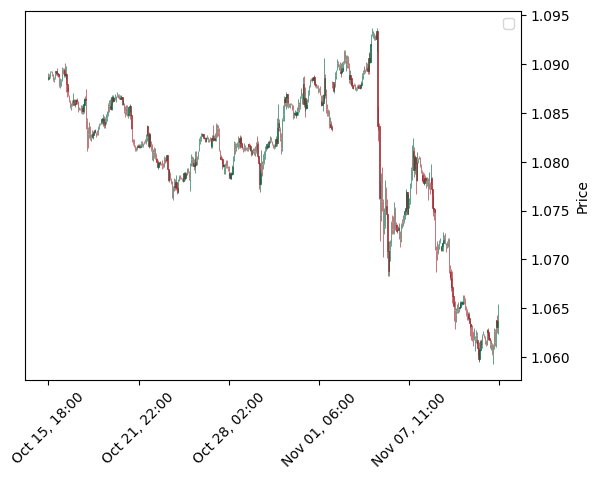

In [ ]:
import oandapyV20
from oandapyV20.endpoints import instruments, orders
from oandapyV20.endpoints.accounts import AccountDetails
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

# OANDA API credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# 1. Fetch historical price data
def fetch_candles(instrument, granularity="H1", count=500):
    params = {"granularity": granularity, "count": count}
    candles = instruments.InstrumentsCandles(instrument=instrument, params=params)
    response = client.request(candles)
    df = pd.DataFrame([
        {
            "time": candle['time'],
            "open": float(candle['mid']['o']),
            "high": float(candle['mid']['h']),
            "low": float(candle['mid']['l']),
            "close": float(candle['mid']['c'])
        }
        for candle in response['candles'] if candle['complete']
    ])
    df['time'] = pd.to_datetime(df['time'])
    return df.set_index('time')

# 2. Calculate moving averages
def calculate_moving_averages(df, short_period=50, long_period=200):
    df['MA50'] = df['close'].rolling(window=short_period).mean()
    df['MA200'] = df['close'].rolling(window=long_period).mean()
    return df

# 3. Calculate RSI
def calculate_rsi(df, period=14):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

# 4. Calculate MACD
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    df['EMA12'] = df['close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
    return df

# 5. Define the T-Wave trading strategy
def identify_t_wave_trades(df):
    trades = []
    for i in range(1, len(df)):
        if df['MA50'].iloc[i] > df['MA200'].iloc[i]:  # Uptrend
            if df['RSI'].iloc[i] < 30 and df['MACD'].iloc[i] > df['MACD_signal'].iloc[i]:
                entry_price = df['close'].iloc[i]
                stop_loss = entry_price * 0.98
                take_profit = entry_price * 1.04
                trades.append((df.index[i], 'buy', entry_price, stop_loss, take_profit))

        elif df['MA50'].iloc[i] < df['MA200'].iloc[i]:  # Downtrend
            if df['RSI'].iloc[i] > 70 and df['MACD'].iloc[i] < df['MACD_signal'].iloc[i]:
                entry_price = df['close'].iloc[i]
                stop_loss = entry_price * 1.02
                take_profit = entry_price * 0.96
                trades.append((df.index[i], 'sell', entry_price, stop_loss, take_profit))
    return trades

# 6. Place a trade with the OANDA API
def place_trade(instrument, units, side, take_profit, stop_loss):
    data = {
        "order": {
            "instrument": instrument,
            "units": str(units) if side == "buy" else str(-units),
            "type": "MARKET",
            "timeInForce": "FOK",
            "takeProfitOnFill": {"price": str(take_profit)},
            "stopLossOnFill": {"price": str(stop_loss)}
        }
    }
    order = orders.OrderCreate(accountID=ACCOUNT_ID, data=data)
    response = client.request(order)
    return response

# 7. Run the T-Wave strategy
def t_wave_strategy():
    instrument = "EUR_USD"
    df = fetch_candles(instrument, granularity="H1", count=500)
    df = calculate_moving_averages(df)
    df = calculate_rsi(df)
    df = calculate_macd(df)

    # Identify trade signals
    trades = identify_t_wave_trades(df)

    # Execute trades
    for trade in trades:
        date, side, entry_price, stop_loss, take_profit = trade
        units = 1000  # Define your position size
        print(f"Trade Signal - {side.upper()} on {date}: Entry {entry_price}, Stop Loss {stop_loss}, Take Profit {take_profit}")

        # Uncomment below line to place real orders (make sure you are in demo environment)
        # place_trade(instrument, units, side, take_profit, stop_loss)

    # Visualize trades
    visualize_trades(df, trades)

# 8. Visualize trades on a candlestick chart
def visualize_trades(df, trades):
    fig, ax = plt.subplots()
    mpf.plot(df, type='candle', style='charles', ax=ax, volume=False)

    for trade in trades:
        date, side, entry_price, stop_loss, take_profit = trade
        color = 'green' if side == 'buy' else 'red'
        ax.axhline(y=entry_price, color=color, linestyle='--', label=f'{side.capitalize()} Entry: {entry_price}')
        ax.axhline(y=stop_loss, color='blue', linestyle=':', label=f'Stop Loss: {stop_loss}')
        ax.axhline(y=take_profit, color='orange', linestyle=':', label=f'Take Profit: {take_profit}')

    ax.legend()
    plt.show()

# Run the T-Wave strategy
t_wave_strategy()


In [ ]:
import oandapyV20
from oandapyV20.endpoints import instruments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime

# OANDA API credentials

ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)



# 1. Fetch historical price data
def fetch_candles(instrument, granularity="D", start="2020-01-01", end="2023-01-01"):
    params = {
        "granularity": granularity,
        "from": start,
        "to": end,
        "price": "M"
    }
    candles = instruments.InstrumentsCandles(instrument=instrument, params=params)
    response = client.request(candles)
    df = pd.DataFrame([
        {
            "time": candle['time'],
            "open": float(candle['mid']['o']),
            "high": float(candle['mid']['h']),
            "low": float(candle['mid']['c']),
            "close": float(candle['mid']['c'])
        }
        for candle in response['candles'] if candle['complete']
    ])
    df['time'] = pd.to_datetime(df['time'])
    return df.set_index('time')

# 2. Calculate moving averages
def calculate_moving_averages(df, short_period=50, long_period=200):
    df['MA50'] = df['close'].rolling(window=short_period).mean()
    df['MA200'] = df['close'].rolling(window=long_period).mean()
    return df

# 3. Calculate RSI
def calculate_rsi(df, period=14):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

# 4. Calculate MACD
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    df['EMA12'] = df['close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
    return df

# 5. Define the T-Wave trading strategy
def identify_t_wave_trades(df):
    trades = []
    for i in range(1, len(df)):
        if df['MA50'].iloc[i] > df['MA200'].iloc[i]:  # Uptrend
            if df['RSI'].iloc[i] < 30 and df['MACD'].iloc[i] > df['MACD_signal'].iloc[i]:
                entry_price = df['close'].iloc[i]
                stop_loss = entry_price * 0.98
                take_profit = entry_price * 1.04
                trades.append((df.index[i], 'buy', entry_price, stop_loss, take_profit))

        elif df['MA50'].iloc[i] < df['MA200'].iloc[i]:  # Downtrend
            if df['RSI'].iloc[i] > 70 and df['MACD'].iloc[i] < df['MACD_signal'].iloc[i]:
                entry_price = df['close'].iloc[i]
                stop_loss = entry_price * 1.02
                take_profit = entry_price * 0.96
                trades.append((df.index[i], 'sell', entry_price, stop_loss, take_profit))
    return trades

# 6. Track and log each trade in a DataFrame
def log_trade(trade_log, date, trade_type, entry_price, exit_price, stop_loss, take_profit):
    # Determine if trade was a win or loss
    result = "Win" if (trade_type == "buy" and exit_price >= take_profit) or (trade_type == "sell" and exit_price <= take_profit) else "Loss"
    profit_loss = (exit_price - entry_price) if trade_type == "buy" else (entry_price - exit_price)
    trade_log = trade_log.append({
        "Date": date,
        "Type": trade_type,
        "Entry Price": entry_price,
        "Exit Price": exit_price,
        "Stop Loss": stop_loss,
        "Take Profit": take_profit,
        "Result": result,
        "Profit/Loss": profit_loss
    }, ignore_index=True)
    return trade_log

# 7. Summarize the performance
def summarize_performance(trade_log):
    total_trades = len(trade_log)
    winning_trades = len(trade_log[trade_log['Result'] == 'Win'])
    losing_trades = total_trades - winning_trades
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0

    avg_win = trade_log[trade_log['Result'] == 'Win']['Profit/Loss'].mean()
    avg_loss = trade_log[trade_log['Result'] == 'Loss']['Profit/Loss'].mean()
    risk_reward_ratio = -avg_win / avg_loss if avg_loss else 0
    profit_factor = trade_log[trade_log['Profit/Loss'] > 0]['Profit/Loss'].sum() / abs(trade_log[trade_log['Profit/Loss'] < 0]['Profit/Loss'].sum())

    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades} ({win_rate:.2f}%)")
    print(f"Losing Trades: {losing_trades}")
    print(f"Average Win: {avg_win:.2f}")
    print(f"Average Loss: {avg_loss:.2f}")
    print(f"Risk-Reward Ratio: {risk_reward_ratio:.2f}")
    print(f"Profit Factor: {profit_factor:.2f}")

# 8. Visualize trades on the price chart
def plot_trades(df, trade_log):
    plt.figure(figsize=(12, 6))
    plt.plot(df['close'], label='Close Price')

    for _, trade in trade_log.iterrows():
        color = 'green' if trade['Type'] == 'buy' else 'red'
        plt.axvline(x=trade['Date'], color=color, linestyle='--', label=f"{trade['Type'].capitalize()} Trade")
        plt.scatter(trade['Date'], trade['Entry Price'], color=color, marker='^' if trade['Type'] == 'buy' else 'v')

    plt.legend()
    plt.title('Trade Entries and Exits')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

# 9. Run the T-Wave strategy and backtest
def t_wave_backtest():
    instrument = "EUR_USD"
    df = fetch_candles(instrument, granularity="D", start="2020-01-01", end="2023-01-01")
    df = calculate_moving_averages(df)
    df = calculate_rsi(df)
    df = calculate_macd(df)

    trade_log = pd.DataFrame(columns=["Date", "Type", "Entry Price", "Exit Price", "Stop Loss", "Take Profit", "Result", "Profit/Loss"])  # Initialize trade log
    trades = identify_t_wave_trades(df)

    for trade in trades:
        date, side, entry_price, stop_loss, take_profit = trade
        exit_price = take_profit if side == "buy" else stop_loss  # Simplification for backtest
        trade_log = log_trade(trade_log, date, side, entry_price, exit_price, stop_loss, take_profit)

    summarize_performance(trade_log)
    plot_trades(df, trade_log)

# Execute the backtest
t_wave_backtest()



AttributeError: 'DataFrame' object has no attribute 'append'